In [1]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from tqdm import tqdm
import IPython.display as ipd

# Konfigurasi Tampilan
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# Path Data Asli (Gunakan salah satu file sampel dari setiap mood)
# Pastikan path ini benar mengarah ke folder data mentah Anda
DATA_DIR = 'data/split/train' 

# Ambil 1 sampel file dari setiap mood secara otomatis
sample_files = {}
if os.path.exists(DATA_DIR):
    for mood in os.listdir(DATA_DIR):
        mood_dir = os.path.join(DATA_DIR, mood)
        if os.path.isdir(mood_dir):
            files = [f for f in os.listdir(mood_dir) if f.endswith('.wav') or f.endswith('.mp3')]
            if files:
                sample_files[mood] = os.path.join(mood_dir, files[0]) # Ambil file pertama
                print(f"✅ Sampel {mood}: {files[0]}")
else:
    print("❌ Folder data tidak ditemukan!")

✅ Sampel angry: Connor Kauffman - Cry (Lyrics).wav
✅ Sampel happy: Anne Marie - 2002 .wav
✅ Sampel relaxed: Attack On Titan OST- Call of Silence (Lyrics) - ThatOnePotato.wav
✅ Sampel sad: Adele - Hello (Official Music Video).mp3


In [2]:
def get_slices(y, sr):
    total_samples = len(y)
    duration = total_samples / sr
    
    slices = {}
    
    # 1. Full Song
    slices['Full Song'] = y
    
    # 2. Middle 50% (Potong 25% awal & 25% akhir)
    start_mid = int(total_samples * 0.25)
    end_mid = int(total_samples * 0.75)
    slices['Middle 50%'] = y[start_mid:end_mid]
    
    # 3. Front 30% (Intro)
    end_front = int(total_samples * 0.30)
    slices['Front 30%'] = y[:end_front]
    
    # 4. Back 30% (Outro)
    start_back = int(total_samples * 0.70)
    slices['Back 30%'] = y[start_back:]
    
    # 5. Random 3-Sec Segment (Simulasi Segmentasi)
    # Ambil segmen dari detik ke-30 (atau tengah kalau pendek)
    mid_point = int(total_samples / 2)
    seg_len = 3 * sr
    start_seg = mid_point
    if start_seg + seg_len > total_samples: start_seg = 0
    slices['3-Sec Segment'] = y[start_seg : start_seg + seg_len]
    
    return slices, duration


🎵 Menganalisis Mood: ANGRY
   Durasi Asli: 125.06 detik


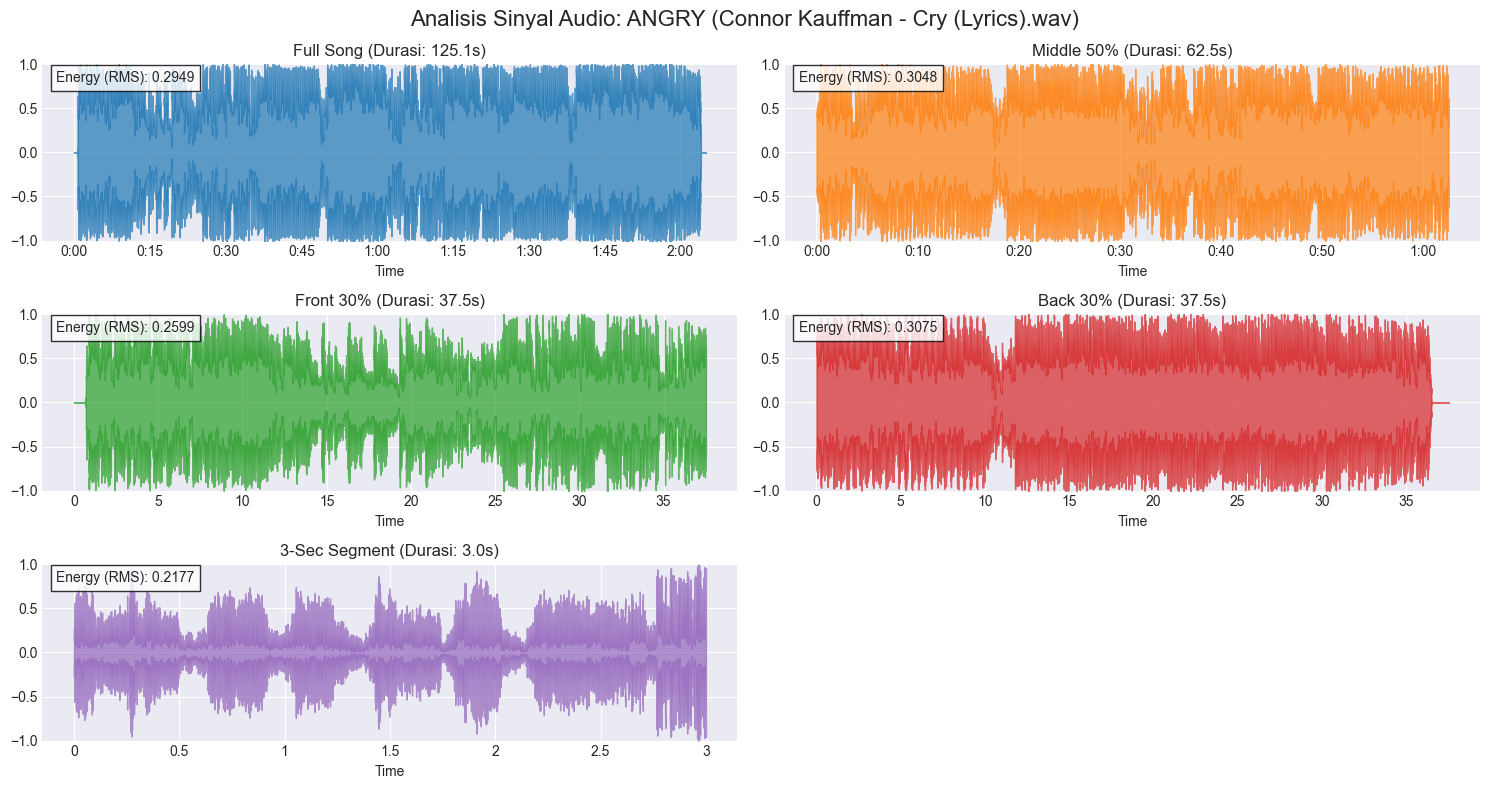


🎵 Menganalisis Mood: HAPPY
   Durasi Asli: 190.01 detik


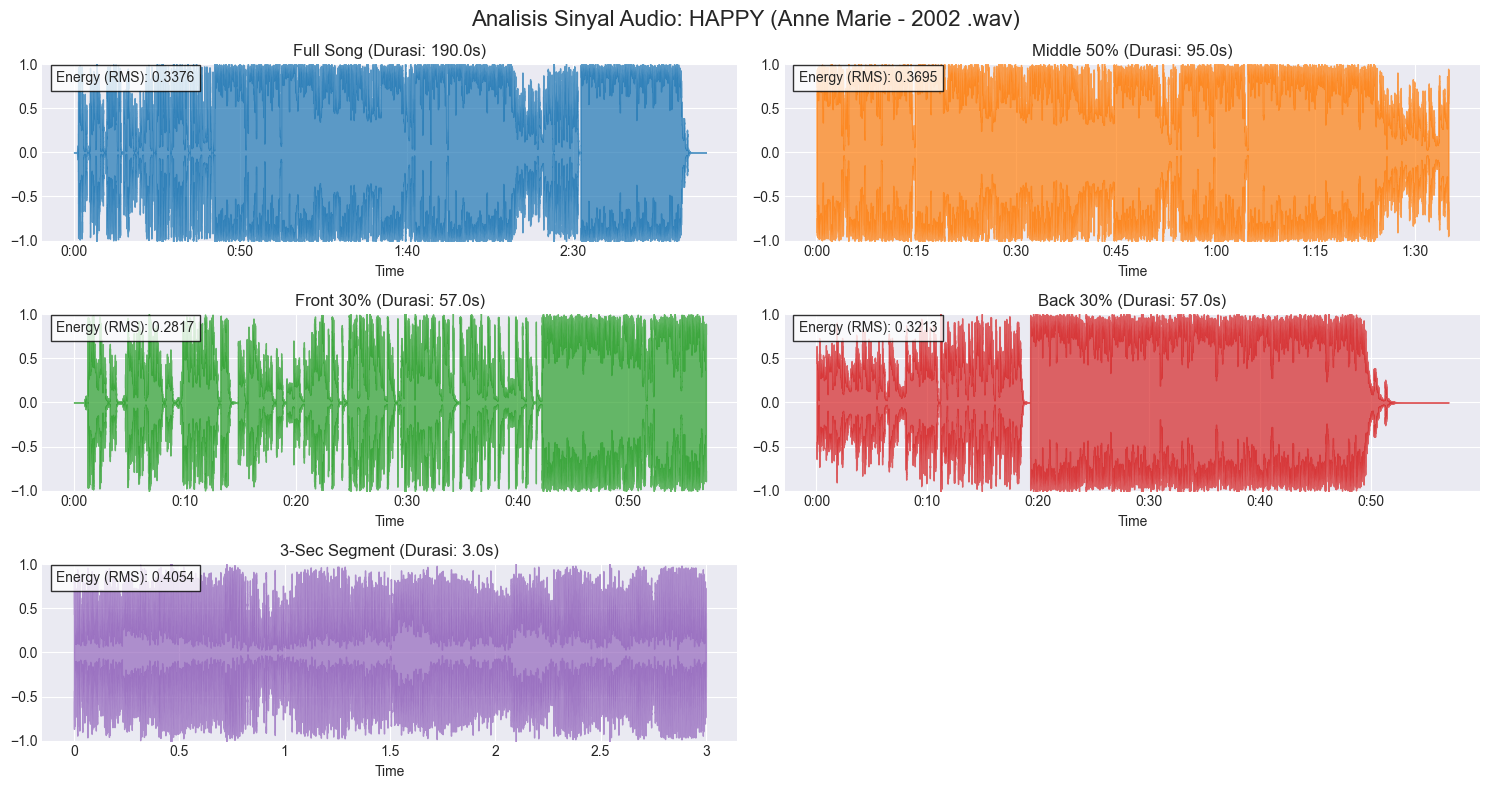


🎵 Menganalisis Mood: RELAXED
   Durasi Asli: 182.09 detik


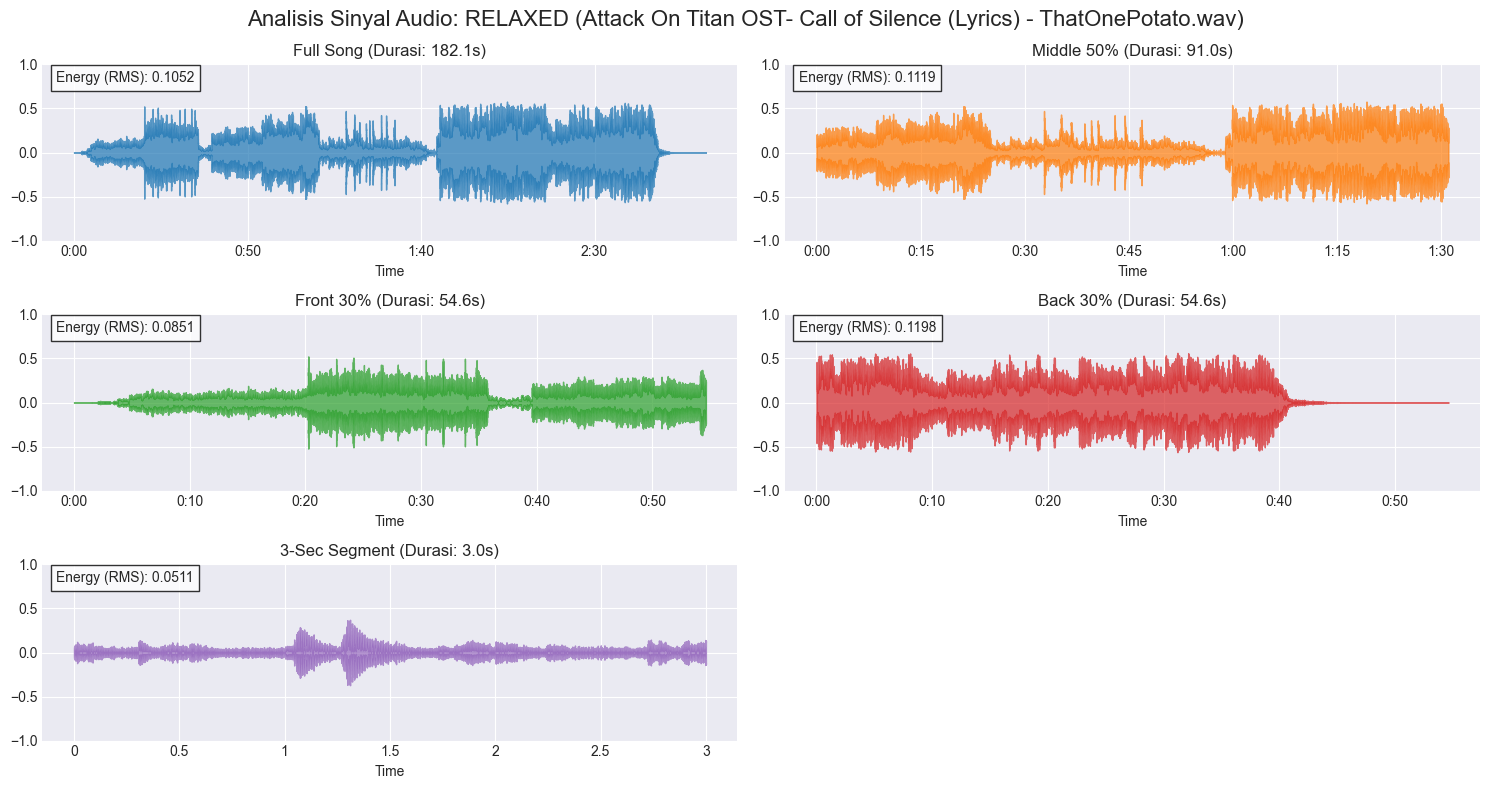


🎵 Menganalisis Mood: SAD
   Durasi Asli: 366.90 detik


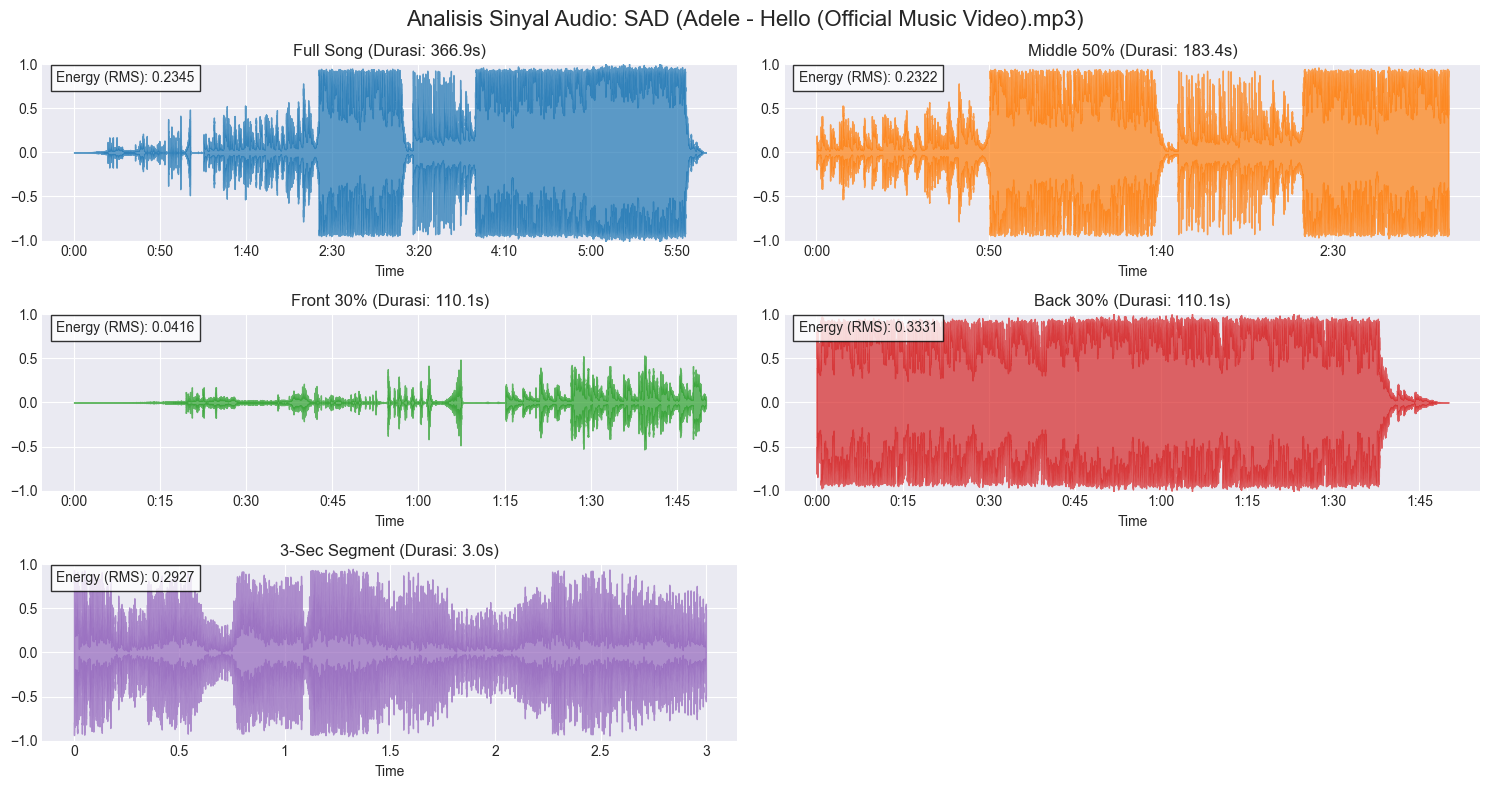

In [3]:
def plot_comparisons(mood, file_path):
    print(f"\n🎵 Menganalisis Mood: {mood.upper()}")
    y, sr = librosa.load(file_path, sr=22050) # Resample standar
    
    slices, duration = get_slices(y, sr)
    print(f"   Durasi Asli: {duration:.2f} detik")
    
    plt.figure(figsize=(15, 8))
    plt.suptitle(f"Analisis Sinyal Audio: {mood.upper()} ({os.path.basename(file_path)})", fontsize=16)
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    for i, (label, audio_data) in enumerate(slices.items()):
        plt.subplot(3, 2, i+1)
        librosa.display.waveshow(audio_data, sr=sr, color=colors[i], alpha=0.7)
        plt.title(f"{label} (Durasi: {len(audio_data)/sr:.1f}s)")
        plt.ylim(-1, 1) # Samakan skala amplitudo
        
        # Hitung Energi Rata-rata (RMS)
        rms = np.sqrt(np.mean(audio_data**2))
        plt.text(0.02, 0.9, f"Energy (RMS): {rms:.4f}", transform=plt.gca().transAxes, 
                 bbox=dict(facecolor='white', alpha=0.8))
        
    plt.tight_layout()
    plt.show()
    
    # Putar Audio (Opsional - Uncomment jika ingin dengar)
    # print("🔊 Dengar Middle 50%:")
    # ipd.display(ipd.Audio(slices['Middle 50%'], rate=sr))

# JALANKAN VISUALISASI UNTUK SEMUA MOOD
for mood, file_path in sample_files.items():
    plot_comparisons(mood, file_path)

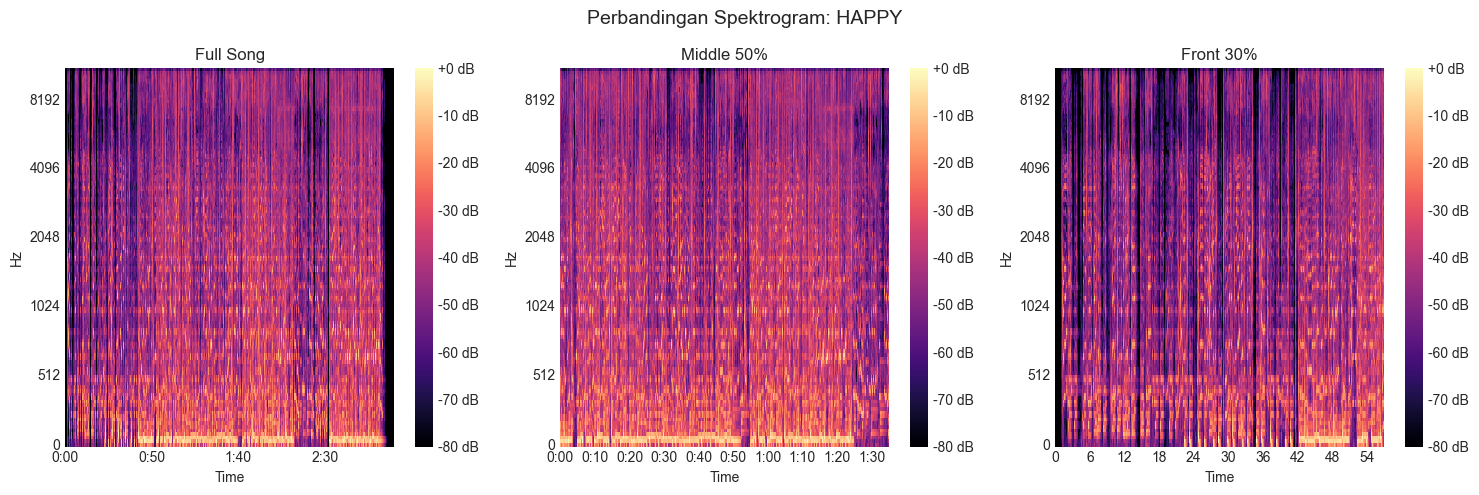

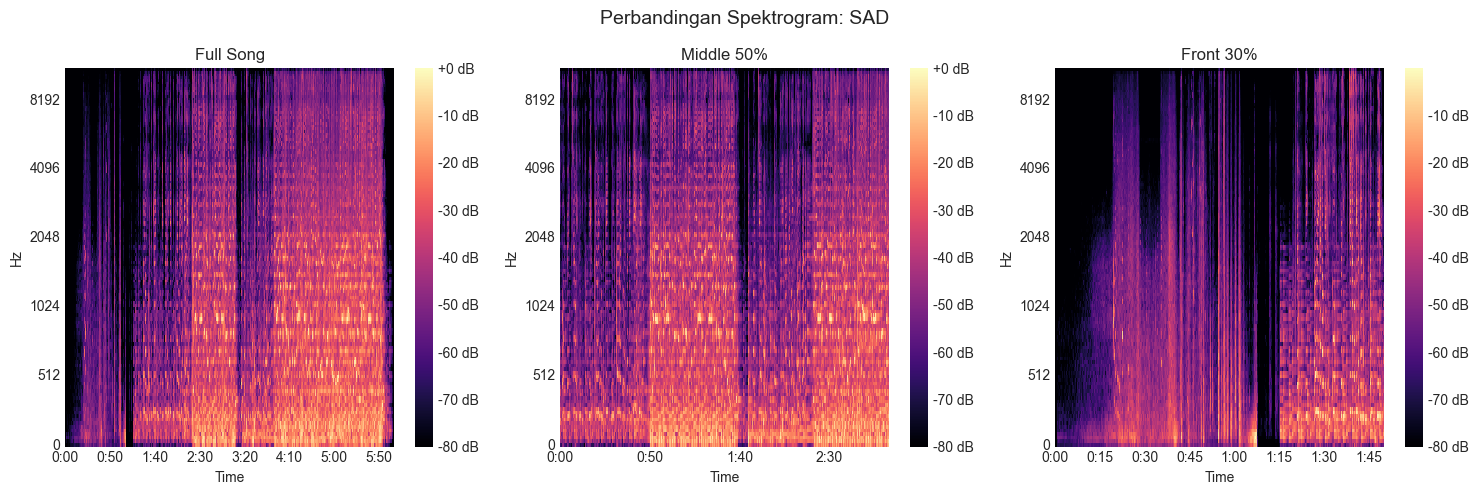

In [4]:
def plot_spectrograms(mood, file_path):
    y, sr = librosa.load(file_path, sr=22050)
    slices, _ = get_slices(y, sr)
    
    # Kita bandingkan 3 yang utama: Full, Middle, Front
    targets = ['Full Song', 'Middle 50%', 'Front 30%']
    
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Perbandingan Spektrogram: {mood.upper()}", fontsize=14)
    
    for i, label in enumerate(targets):
        audio_data = slices[label]
        
        # Convert ke Mel-Spectrogram (Apa yang dilihat YAMNet)
        S = librosa.feature.melspectrogram(y=audio_data, sr=sr, n_mels=128)
        S_dB = librosa.power_to_db(S, ref=np.max)
        
        plt.subplot(1, 3, i+1)
        librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"{label}")
    
    plt.tight_layout()
    plt.show()

# JALANKAN UNTUK 2 MOOD BERBEDA (Misal: Happy vs Sad)
if 'happy' in sample_files: plot_spectrograms('happy', sample_files['happy'])
if 'sad' in sample_files: plot_spectrograms('sad', sample_files['sad'])